In [1]:
import pandas as pd, numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
from catboost import *
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import shap
from time import time

In [2]:
df = pd.read_csv('mtp_dataset_3_mod.csv')
boring = df[df['life_mode'] == 'boring'].index
df['body_size'] = np.log(df['body_size']) #log transforming body size
df = df.assign(survival_status=df.survival_status.eq('Extinct').astype(int)) #encoding "extinct" as 1 and "survived" as 0
df.drop(['order'], axis = 1, inplace = True) #dropping the column "order"
df.replace('boring', 'infaunal', inplace = True)
df

,lithology,life_mode,motility,feeding_mode,shell_mineralogy,species_richness,ornamentation,environmental_breadth,geographic_range,occurrence,body_size,survival_status
0,mixed,epifaunal,stationary,suspension feeder,aragonite,1,2,2,1,2,3.056486,0
1,siliciclastic,epifaunal,mobile,suspension feeder,aragonite,1,2,4,4,10,4.948570,0
2,siliciclastic,infaunal,mobile,deposit feeder,aragonite,1,2,1,1,1,3.540013,0
3,siliciclastic,infaunal,mobile,deposit feeder,aragonite,4,2,5,4,33,1.085132,0
4,mixed,epifaunal,stationary,suspension feeder,low Mg calcite,3,2,2,6,62,4.377049,0
...,...,...,...,...,...,...,...,...,...,...,...,...
303,siliciclastic,epifaunal,stationary,suspension feeder,aragonite,1,2,1,1,5,3.092152,1
304,siliciclastic,infaunal,stationary,suspension feeder,aragonite,1,2,1,1,1,2.973484,0
305,siliciclastic,infaunal,mobile,suspension feeder,aragonite,3,2,3,2,6,4.261218,1
306,siliciclastic,infaunal,mobile,deposit feeder,aragonite,5,1,4,2,15,3.431797,0


In [25]:
#df['survival_status'].value_counts()[1]
df['survival_status'].value_counts()[0]

217

0:	learn: 0.6638282	total: 4.29ms	remaining: 4.28s
1:	learn: 0.6438320	total: 6ms	remaining: 2.99s
2:	learn: 0.6255005	total: 8ms	remaining: 2.66s
3:	learn: 0.6116782	total: 9.79ms	remaining: 2.44s
4:	learn: 0.5891324	total: 11.8ms	remaining: 2.35s
5:	learn: 0.5758896	total: 13.7ms	remaining: 2.28s
6:	learn: 0.5627558	total: 15.3ms	remaining: 2.17s
7:	learn: 0.5538427	total: 16.9ms	remaining: 2.09s
8:	learn: 0.5473550	total: 19ms	remaining: 2.09s
9:	learn: 0.5409096	total: 20.9ms	remaining: 2.06s
10:	learn: 0.5309276	total: 23.7ms	remaining: 2.13s
11:	learn: 0.5276440	total: 25.2ms	remaining: 2.08s
12:	learn: 0.5217927	total: 27.9ms	remaining: 2.12s
13:	learn: 0.5113829	total: 30.2ms	remaining: 2.13s
14:	learn: 0.5108875	total: 30.5ms	remaining: 2s
15:	learn: 0.5041145	total: 32ms	remaining: 1.97s
16:	learn: 0.4951089	total: 34.1ms	remaining: 1.97s
17:	learn: 0.4854794	total: 35.8ms	remaining: 1.95s
18:	learn: 0.4841707	total: 36.4ms	remaining: 1.88s
19:	learn: 0.4758123	total: 37.9ms	

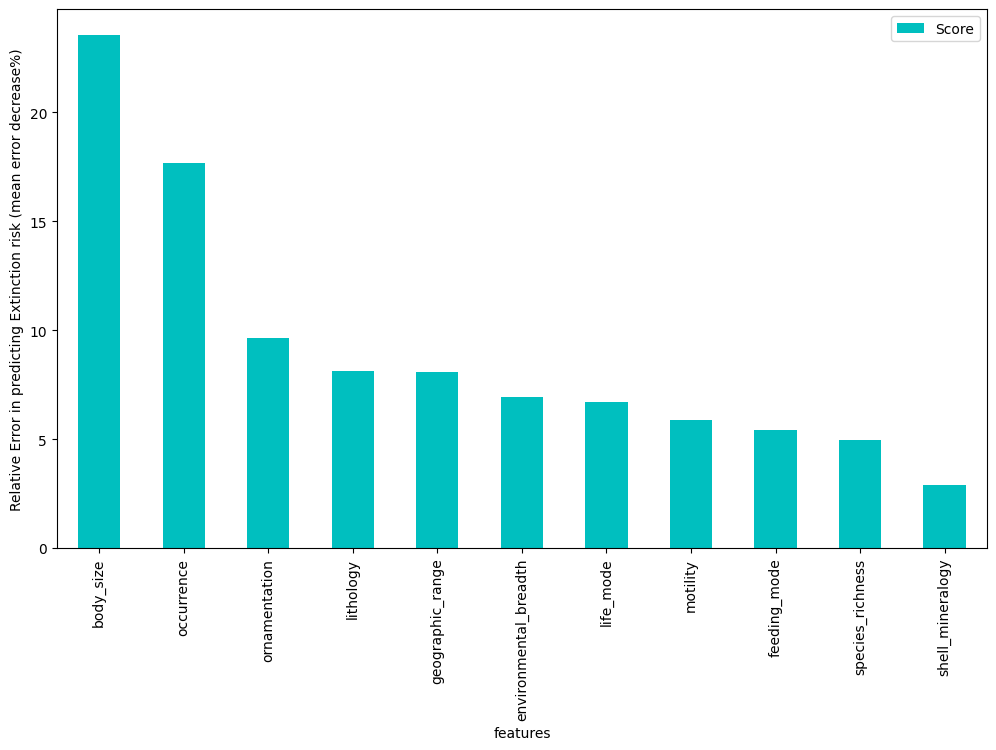

In [19]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

# Load the data
data = df

# Split into features and target
X = data.drop('survival_status', axis=1)
y = data['survival_status']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the categorical features
categorical_features_indices = [0,1,2,3,4]

# Use SMOTE to address class imbalance
sm = SMOTENC(categorical_features=[0,1,2,3,4], random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Create the CatBoost Pool object for training and testing
train_pool = Pool(X_train_res, y_train_res, cat_features=categorical_features_indices)
test_pool = Pool(X_test, cat_features=categorical_features_indices)

# Define the CatBoost classifier
clf = CatBoostClassifier(iterations=1000, 
                         depth=6, 
                         learning_rate=0.1, 
                         loss_function='Logloss', 
                         verbose=True)

# Train the model on the full dataset
clf.fit(X, y, cat_features=categorical_features_indices)

# Get the feature importance using PredictionValuesChange
feature_importance = clf.get_feature_importance(type='PredictionValuesChange')

# Print the feature importance values
for i in range(len(X.columns)):
    print('{}: {}'.format(X.columns[i], feature_importance[i]))

fi = clf.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type='PredictionValuesChange')
feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, fi )),
                                        columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
print(feature_score)

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
#ax.set_title("Feature Importance using {}".format('PredictionValuesChange'), fontsize = 14)
ax.set_ylabel("Relative Error in predicting Extinction risk (mean error decrease%)")
ax.set_xlabel("features")
plt.show()

In [26]:
#function to create and print the confusion matrix and the precision recall and F1 scores
from sklearn.metrics import confusion_matrix
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Extinct','Survived']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='Yellow')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp+tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Accuracy={0:0.3f}'.format(accuracy))
    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

#function to create the precision- recall curve
from sklearn.metrics import average_precision_score, precision_recall_curve
def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=0)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

#function to create the ROC cureve
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
def plot_aucroc(classifier):
    probs = classifier.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [30]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

# Load the data
data = df

# Split into features and target
X = data.drop('survival_status', axis=1)
y = data['survival_status']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the categorical features
categorical_features_indices = [0,1,2,3,4]

# Use SMOTE to address class imbalance
sm = SMOTENC(categorical_features=[0,1,2,3,4], random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Create the CatBoost Pool object for training and testing
train_pool = Pool(X_train_res, y_train_res, cat_features=categorical_features_indices)
test_pool = Pool(X_test, cat_features=categorical_features_indices)

# Define the CatBoost classifier
clf = CatBoostClassifier(iterations=1000, 
                         depth=6, 
                         learning_rate=0.1, 
                         loss_function='Logloss', 
                         verbose=True)


#clf.fit(X_train_res, y_train_res, cat_features=categorical_features_indices)
clf.fit(train_pool, eval_set=test_pool)

0:	learn: 0.6659732	total: 3.1ms	remaining: 3.1s
1:	learn: 0.6376234	total: 5.9ms	remaining: 2.94s
2:	learn: 0.6101764	total: 7.49ms	remaining: 2.49s
3:	learn: 0.5975399	total: 8.44ms	remaining: 2.1s
4:	learn: 0.5783222	total: 9.58ms	remaining: 1.91s
5:	learn: 0.5591198	total: 12.2ms	remaining: 2.02s
6:	learn: 0.5485109	total: 14.5ms	remaining: 2.06s
7:	learn: 0.5335616	total: 17.4ms	remaining: 2.15s
8:	learn: 0.5250336	total: 18.9ms	remaining: 2.08s
9:	learn: 0.5172206	total: 20.2ms	remaining: 2s
10:	learn: 0.5020611	total: 21.2ms	remaining: 1.9s
11:	learn: 0.4912589	total: 23.3ms	remaining: 1.92s
12:	learn: 0.4785437	total: 24.5ms	remaining: 1.86s
13:	learn: 0.4730796	total: 25.3ms	remaining: 1.78s
14:	learn: 0.4684547	total: 26.7ms	remaining: 1.75s
15:	learn: 0.4572795	total: 28ms	remaining: 1.72s
16:	learn: 0.4554981	total: 28.9ms	remaining: 1.67s
17:	learn: 0.4503247	total: 30.2ms	remaining: 1.65s
18:	learn: 0.4489440	total: 30.8ms	remaining: 1.59s
19:	learn: 0.4409332	total: 32.2

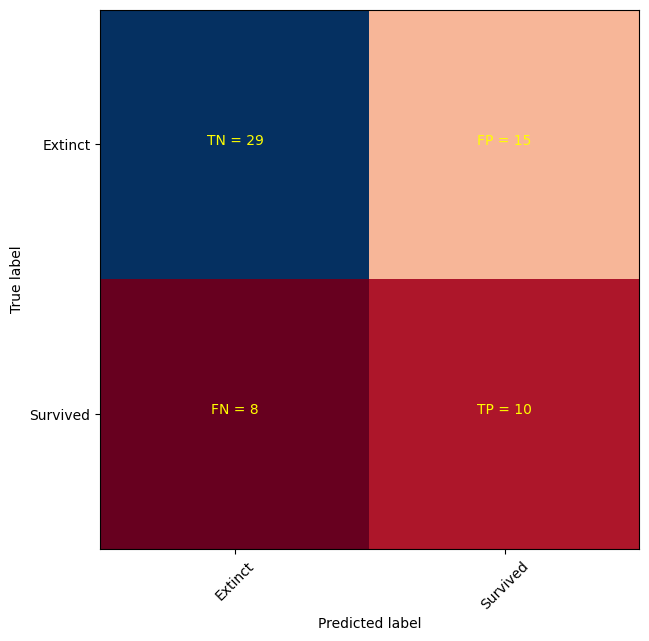

Accuracy=0.629
Recall=0.556 
Precision=0.400
F1=0.465
Average precision-recall score: 0.423


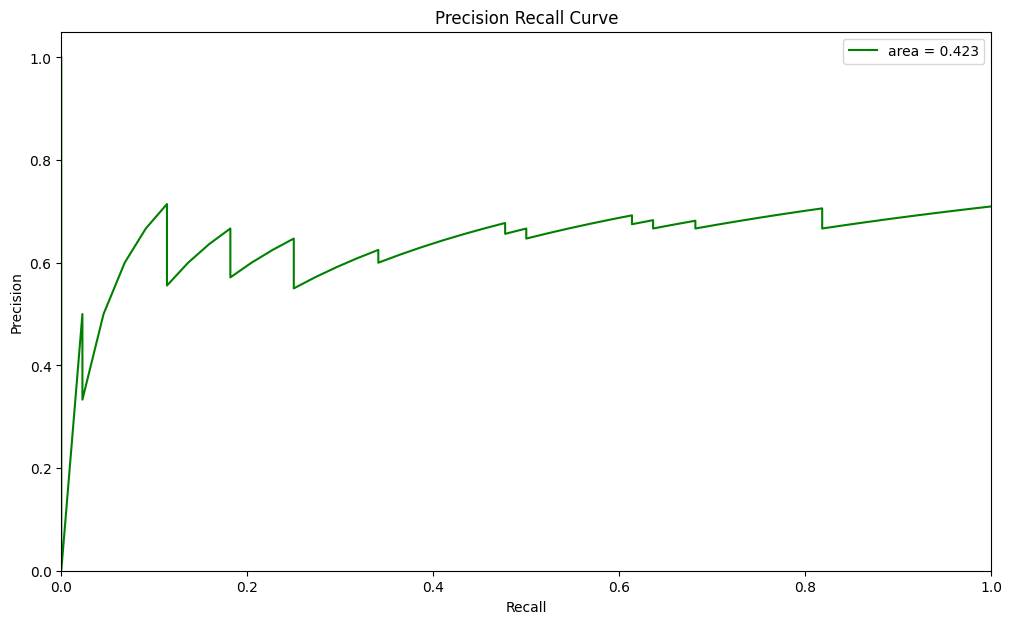

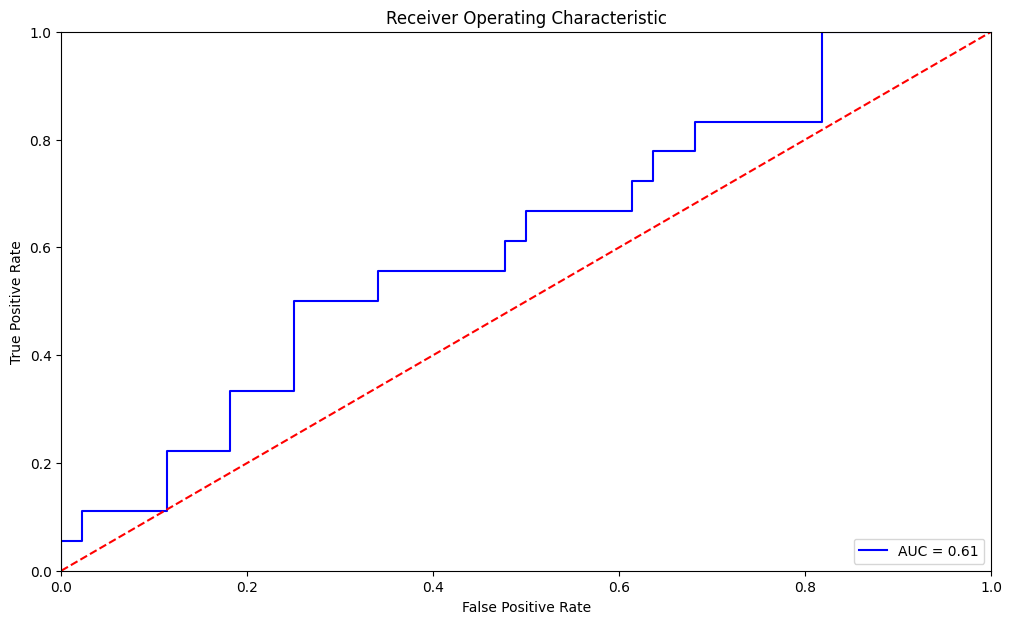

In [34]:
#Make predictions
y_pred = clf.predict(test_pool)
try:
    scores = clf.decision_function(test_pool)
except:
    scores = clf.predict_proba(test_pool)[:,1]

#Make plots
plot_cm(clf, y_pred)
plot_aucprc(clf, scores)
plot_aucroc(clf)

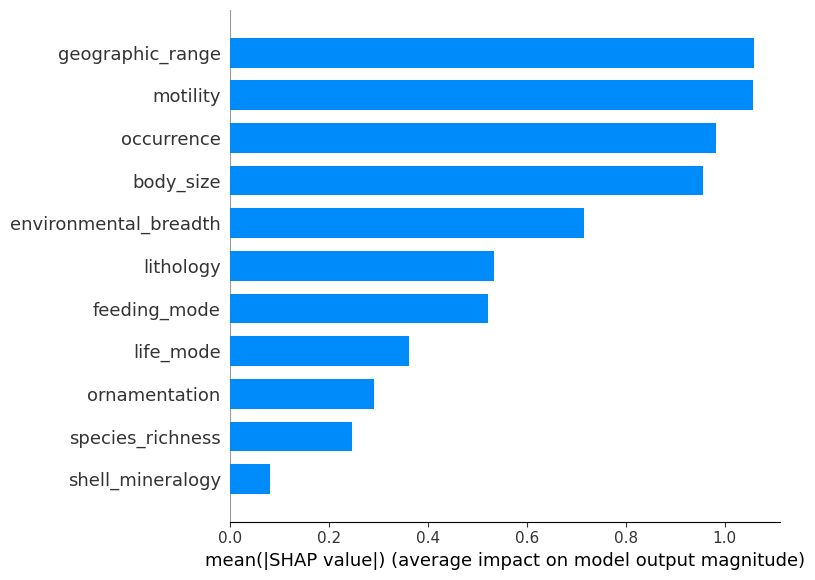

In [35]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")